In [148]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import (ImageDataGenerator, 
                                                  array_to_img, img_to_array, 
                                                  load_img) 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.image as mpimg
import pathlib
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint



    rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
    width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
    rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
    shear_range is for randomly applying shearing transformations
    zoom_range is for randomly zooming inside pictures
    horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
    fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.


In [150]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale = 1/255,
        shear_range = 0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
        )

In [171]:
#  Added for Tensorboard
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=2,
                          batch_size=16,
                          write_graph=True,
                          write_grads=True,
                          write_images=True,

                         ) 
early_stopping = EarlyStopping(restore_best_weights = True, patience = 2, monitor='val_loss')
# modified for Tensorboard


W0915 00:00:16.864140 140576549357312 callbacks.py:1191] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.
W0915 00:00:16.866708 140576549357312 callbacks.py:1197] `batch_size` is no longer needed in the `TensorBoard` Callback and will be ignored in TensorFlow 2.0.


In [164]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

loss_fn = keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0,
    reduction="auto",
    name="categorical_crossentropy",
)

model.compile(loss=loss_fn, optimizer='adam', metrics=['accuracy'])

# the model so far outputs 3D feature maps (height, width, features)

In [165]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../images/Images/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use CategoricalCrossentropy loss, we need categorical labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../images/Images/val',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 664 images belonging to 5 classes.
Found 143 images belonging to 5 classes.


In [168]:
epochs = 10
history = model.fit(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=800 // batch_size,
        verbose = 1,
        callbacks=[tensorboard, early_stopping])
# model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/10
125/125 [==============================] - 37s 293ms/step - loss: 25.7117 - accuracy: 0.2561 - val_loss: 25.2089 - val_accuracy: 0.2654
Epoch 2/10
125/125 [==============================] - 45s 362ms/step - loss: 24.7841 - accuracy: 0.2849 - val_loss: 24.4018 - val_accuracy: 0.3799
Epoch 3/10
125/125 [==============================] - 44s 351ms/step - loss: 23.5933 - accuracy: 0.3350 - val_loss: 23.3956 - val_accuracy: 0.3472
Epoch 4/10
125/125 [==============================] - 40s 321ms/step - loss: 22.9273 - accuracy: 0.3644 - val_loss: 23.1205 - val_accuracy: 0.3912
Epoch 5/10
125/125 [==============================] - 38s 302ms/step - loss: 21.4369 - accuracy: 0.4266 - val_loss: 22.4966 - val_accuracy: 0.3547
Epoch 6/10
125/125 [==============================] - 37s 298ms/step - loss: 20.6065 - accuracy: 0.4560 - val_loss: 21.3186 - val_accuracy: 0.4642
Epoch 7/10
125/125 [==============================] - 37s 295ms/step - loss: 19.2199 - accuracy: 0.4995 - val_loss: 21

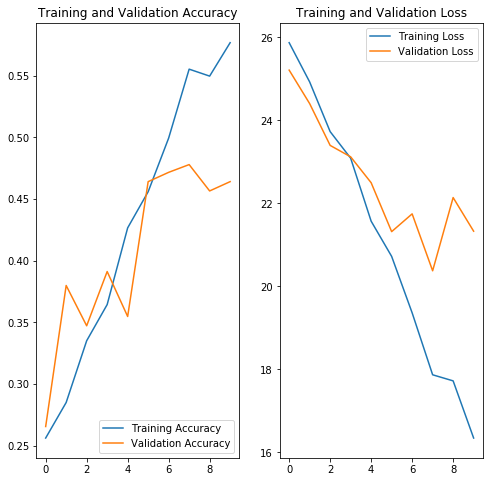

In [169]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [170]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_71 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_72 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 34, 34, 64)      

In [172]:
!tensorboard --logdir=logs/ --port=8889

W0915 00:00:34.606614 140566483171072 plugin_event_accumulator.py:294] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0915 00:00:34.626572 140566483171072 plugin_event_accumulator.py:294] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
TensorBoard 1.14.0a20190301 at http://43a7ce3886b3:8889 (Press CTRL+C to quit)
^C


VGG16 architecture, pre-trained on the ImageNet dataset 

In [173]:
from tensorflow.keras.applications import VGG16, xception



def create_transfer_model(input_size, n_categories, weights = 'imagenet', trans_mod=VGG16):
        # note that the "top" is not included in the weights below
        base_model = tras_mod(weights=weights,
                          include_top=False,
                          input_shape=input_size)
        
        model = base_model.output
        
        # add new head
        model = GlobalAveragePooling2D()(model)
        predictions = Dense(n_categories, activation='softmax')(model)
        model = Model(inputs=base_model.input, outputs=predictions)
        
        return model
    


In [174]:
transfer_model = create_transfer_model(input_size=(150,150,3), n_categories=5)

In [175]:
def print_model_properties(model, indices = 0):
     for i, layer in enumerate(model.layers[indices:]):
        print("Layer {} | Name: {} | Trainable: {}".format(i+indices, layer.name, layer.trainable))


Layer 0 | Name: input_4 | Trainable: True
Layer 1 | Name: block1_conv1 | Trainable: True
Layer 2 | Name: block1_conv2 | Trainable: True
Layer 3 | Name: block1_pool | Trainable: True
Layer 4 | Name: block2_conv1 | Trainable: True
Layer 5 | Name: block2_conv2 | Trainable: True
Layer 6 | Name: block2_pool | Trainable: True
Layer 7 | Name: block3_conv1 | Trainable: True
Layer 8 | Name: block3_conv2 | Trainable: True
Layer 9 | Name: block3_conv3 | Trainable: True
Layer 10 | Name: block3_pool | Trainable: True
Layer 11 | Name: block4_conv1 | Trainable: True
Layer 12 | Name: block4_conv2 | Trainable: True
Layer 13 | Name: block4_conv3 | Trainable: True
Layer 14 | Name: block4_pool | Trainable: True
Layer 15 | Name: block5_conv1 | Trainable: True
Layer 16 | Name: block5_conv2 | Trainable: True
Layer 17 | Name: block5_conv3 | Trainable: True
Layer 18 | Name: block5_pool | Trainable: True
Layer 19 | Name: global_average_pooling2d_2 | Trainable: True
Layer 20 | Name: dense_30 | Trainable: True


In [176]:
def change_trainable_layers(model, trainable_index):
    for layer in model.layers[:trainable_index]:
        layer.trainable = False
    for layer in model.layers[trainable_index:]:
        layer.trainable = True
        
        
print_model_properties(transfer_model)
change_trainable_layers(transfer_model, 19)        
print_model_properties(transfer_model)

Layer 0 | Name: input_4 | Trainable: False
Layer 1 | Name: block1_conv1 | Trainable: False
Layer 2 | Name: block1_conv2 | Trainable: False
Layer 3 | Name: block1_pool | Trainable: False
Layer 4 | Name: block2_conv1 | Trainable: False
Layer 5 | Name: block2_conv2 | Trainable: False
Layer 6 | Name: block2_pool | Trainable: False
Layer 7 | Name: block3_conv1 | Trainable: False
Layer 8 | Name: block3_conv2 | Trainable: False
Layer 9 | Name: block3_conv3 | Trainable: False
Layer 10 | Name: block3_pool | Trainable: False
Layer 11 | Name: block4_conv1 | Trainable: False
Layer 12 | Name: block4_conv2 | Trainable: False
Layer 13 | Name: block4_conv3 | Trainable: False
Layer 14 | Name: block4_pool | Trainable: False
Layer 15 | Name: block5_conv1 | Trainable: False
Layer 16 | Name: block5_conv2 | Trainable: False
Layer 17 | Name: block5_conv3 | Trainable: False
Layer 18 | Name: block5_pool | Trainable: False
Layer 19 | Name: global_average_pooling2d_2 | Trainable: True
Layer 20 | Name: dense_30 |

In [177]:
train_generator[0][0].shape


(16, 150, 150, 3)

In [178]:
transfer_model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
mdl_check_trans = ModelCheckpoint(filepath='./logs/best_trans_model.hdf5', save_best_only=True)
history = transfer_model.fit(train_generator,
            steps_per_epoch=2000 // batch_size,
            epochs=10,
            validation_data=validation_generator,
            validation_steps=800 // batch_size,
            verbose = 1,
            callbacks=[tensorboard, early_stopping])


Epoch 1/10
125/125 [==============================] - 266s 2s/step - loss: 1.4955 - accuracy: 0.3588 - val_loss: 1.3533 - val_accuracy: 0.5044
Epoch 2/10
125/125 [==============================] - 243s 2s/step - loss: 1.2953 - accuracy: 0.5329 - val_loss: 1.2007 - val_accuracy: 0.6302
Epoch 3/10
125/125 [==============================] - 213s 2s/step - loss: 1.1681 - accuracy: 0.6002 - val_loss: 1.1158 - val_accuracy: 0.6352
Epoch 4/10
125/125 [==============================] - 213s 2s/step - loss: 1.0700 - accuracy: 0.6437 - val_loss: 1.0496 - val_accuracy: 0.6377
Epoch 5/10
125/125 [==============================] - 214s 2s/step - loss: 1.0239 - accuracy: 0.6624 - val_loss: 1.0190 - val_accuracy: 0.6818
Epoch 6/10
125/125 [==============================] - 213s 2s/step - loss: 0.9729 - accuracy: 0.6791 - val_loss: 0.9901 - val_accuracy: 0.6692
Epoch 7/10
125/125 [==============================] - 212s 2s/step - loss: 0.9316 - accuracy: 0.6953 - val_loss: 0.9707 - val_accuracy: 0.6918

In [ ]:
!tensorboard --logdir=logs/ --port=8889

W0915 00:41:50.795947 140111684011776 plugin_event_accumulator.py:294] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0915 00:41:50.822227 140111684011776 plugin_event_accumulator.py:294] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0915 00:41:50.852664 140111684011776 plugin_event_accumulator.py:294] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
TensorBoard 1.14.0a20190301 at http://43a7ce3886b3:8889 (Press CTRL+C to quit)


In [ ]:
change_trainable_layers(transfer_model, 18)

transfer_model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
# mdl_check_trans = ModelCheckpoint(filepath='models/best_trans_model.hdf5',
#                             save_best_only=True)
history = transfer_model.fit(train_generator,
            steps_per_epoch=2000 // batch_size,
            epochs=10,
            validation_data=validation_generator,
            validation_steps=800 // batch_size)


In [ ]:
transfer_model = create_transfer_model(input_size=(150,150,3), n_categories=5, trans_mod = xception)
print_model_properties(transfer_model)
# change_trainable_layers(transfer_model, 19)        
# print_model_properties(transfer_model)